# Data Mining - StarCraft Player Prediction

The goal of the project was it to predict which player is playing a certain game based on the moves he or she made.

In [5]:
# imports
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from itertools import groupby, combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
# Suppress all warnings
warnings.simplefilter("ignore")

## Pre-processing Training Data

To train a model we were given data where each row represented a gameplay. A row included information about the race, the player who was playing and the moves he or she made during the game. 

In [2]:
# Load the training dataset
train_data = pd.read_csv('train_data.csv', delimiter=';')

# Drop unnecessary columns
train_data = train_data.drop(['PlayerURL', 'PlayerName'], axis=1)

train_data.head()

,PlayerID,Race,Move 1,Move 2,Move 3,Move 4,Move 5,Move 6,Move 7,Move 8,...,Move 2554,Move 2555,Move 2556,Move 2557,Move 2558,Move 2559,Move 2560,Move 2561,Move 2562,Move 2563
0,1021189,Terran,s,hotkey11,hotkey21,hotkey31,hotkey41,hotkey51,hotkey61,s,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1021189,Terran,s,s,hotkey11,hotkey21,hotkey31,hotkey41,hotkey51,hotkey61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1021189,Terran,s,hotkey11,hotkey21,hotkey31,hotkey41,hotkey51,hotkey61,hotkey71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1021189,Terran,s,hotkey11,hotkey21,hotkey31,hotkey41,hotkey51,hotkey61,t5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1021189,Terran,s,hotkey11,hotkey21,hotkey31,hotkey41,hotkey51,hotkey71,hotkey61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Before starting with the classification algorithms we had to find a way to process our data and make it comparable. We wanted to reduce dimensions without losing information. In order to do so, we started counting how often a player would use a certain move. We did this over the course of a whole game and also over the course of certain time periods.

In [3]:
def count_moves(row, counts, index):
    total_moves = 0
    for i in range(1, 2564):
        move = row["Move "+ str(i)]
        # count the number of s's
        if move == 's':
            counts[10][index] += 1
        # count the number of Base's
        elif move == 'Base':
            counts[11][index] += 1
        # count the number of SingleMineral's
        elif move == 'SingleMineral':
            counts[12][index] += 1
        # count the hotkeys
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[j][index] += 1

        total_moves += 1  
    # Save the total moves count
    counts[13][index] = total_moves


def count_move_per_time(row, counts, row_index, time_interval, ti_index):
    base_index = ti_index * 14
    total_moves = 0

    for i in range(1, 2564):
        move = row["Move " + str(i)]

        # Count actions for the given time interval
        if move == 's':
            counts[base_index + 10][row_index] += 1
        elif move == 'Base':
            counts[base_index + 11][row_index] += 1
        elif move == 'SingleMineral':
            counts[base_index + 12][row_index] += 1
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[base_index + j][row_index] += 1

        total_moves += 1

        # Counting actions after the specified time interval
        if move == f't{time_interval}':
            break

    counts[base_index + 13][row_index] = total_moves

# Create new table that only contains the first column (PlayerId) of train_data
# Keep only the first column but all rows
train_data_new = train_data.iloc[:, :1]

# Specify the target time intervals
# time_intervals = [20, 60, 100, 200]
time_intervals = [5, 20, 60, 100, 200, 270, 340, 550]

# Calculate how many columns we need
calc_column = len(time_intervals)* 14 + 14

# New lists of counts
counts = [[0] * 3052 for _ in range(calc_column)]

# Go through the rows using the functions to count the actions
for row_index, row in train_data.iterrows():
    count_moves(row, counts, row_index)

    for ti_index, time_interval in enumerate(time_intervals):
        count_move_per_time(row, counts, row_index, time_interval, ti_index+1)

train_data_new["sCount"] = counts[10]
train_data_new["BaseCount"] = counts[11]
train_data_new["singleMineralCount"] = counts[12]

for i in range(10):
    train_data_new[f'hk{i}Count'] = counts[i]

for ti_index, time_interval in enumerate(time_intervals):
    base_index = (ti_index + 1) * 14
    
    train_data_new[f's_t{time_interval}Count'] = counts[base_index + 10]
    train_data_new[f'base_t{time_interval}Count'] =  counts[base_index + 11]
    train_data_new[f'singleMineral_t{time_interval}Count'] = counts[base_index + 12]
    
    for j in range(10):
        column_name = f'hk{j}_t{time_interval}Count'
        train_data_new[column_name] = counts[base_index + j]
    
train_data_new.head()

,PlayerID,sCount,BaseCount,singleMineralCount,hk0Count,hk1Count,hk2Count,hk3Count,hk4Count,hk5Count,...,hk0_t550Count,hk1_t550Count,hk2_t550Count,hk3_t550Count,hk4_t550Count,hk5_t550Count,hk6_t550Count,hk7_t550Count,hk8_t550Count,hk9_t550Count
0,1021189,1245,0,2,0,405,275,83,77,20,...,0,281,115,66,20,2,1,0,0,0
1,1021189,458,0,0,0,382,159,141,44,5,...,0,360,143,141,40,2,1,0,0,0
2,1021189,879,0,8,0,334,222,48,79,16,...,0,184,108,35,32,1,1,1,0,0
3,1021189,956,0,9,0,427,309,86,114,55,...,0,255,161,61,79,1,1,0,0,0
4,1021189,927,0,3,0,396,198,58,107,28,...,0,240,107,33,21,2,1,1,0,0


We then realised this was not very meaningful. How often a player presses a certain key, does not make him or her recognizable. So we decided to focus on frequency of moves. Meaning how frequent a player was using certain moves. Overall and again also over the course of certain time periods. To standardize the data we also created three new columns that mapped the name of the race (which was of type string before) to a zero or a one. Depending on whether this particular race was being played or not. 
Of course, preprocessing also included deleting unnecessary columns like Player URL and Player Name.

In [4]:
def count_moves(row, counts, index):
    total_moves = 0
    for i in range(1, 2564):
        move = row["Move "+ str(i)]
        # count the number of s's
        if move == 's':
            counts[10][index] += 1
        # count the number of Base's
        elif move == 'Base':
            counts[11][index] += 1
        # count the number of SingleMineral's
        elif move == 'SingleMineral':
            counts[12][index] += 1
        # count the hotkeys
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[j][index] += 1

        total_moves += 1  
    # Save the total moves count
    counts[13][index] = total_moves


def count_move_per_time(row, counts, row_index, time_interval, ti_index):
    base_index = ti_index * 14
    total_moves = 0

    for i in range(1, 2564):
        move = row["Move " + str(i)]

        # Count actions for the given time interval
        if move == 's':
            counts[base_index + 10][row_index] += 1
        elif move == 'Base':
            counts[base_index + 11][row_index] += 1
        elif move == 'SingleMineral':
            counts[base_index + 12][row_index] += 1
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[base_index + j][row_index] += 1

        total_moves += 1

        # Counting actions after the specified time interval
        if move == f't{time_interval}':
            break

    counts[base_index + 13][row_index] = total_moves


def mapRaces(races, row_index):
    race = train_data['Race'][row_index]

    if race == "Protoss":
        races[0][row_index] = 1
    elif race == "Terran":
        races[1][row_index] = 1
    elif race == "Zerg":
        races[2][row_index] = 1
        
# Create new table that only contains the first column (PlayerId) of train_data
# Keep only the first column but all rows
train_data_new = train_data.iloc[:, :1]


# Specify the target time intervals
#time_intervals = [20, 60, 100, 200]
time_intervals = [5, 20, 60, 100, 200, 270, 340, 550]

calc_column = len(time_intervals)* 14 + 14

# New lists of counts
counts = [[0] * 3052 for _ in range(calc_column)]
# New lists of races
races = [[0] * 3052 for _ in range(3)]


# Go through the rows using the functions to count the actions, map the races
for row_index, row in train_data.iterrows():
    count_moves(row, counts, row_index)
    mapRaces(races, row_index)

    for ti_index, time_interval in enumerate(time_intervals):
        count_move_per_time(row, counts, row_index, time_interval, ti_index+1)
        

for i in range(calc_column):
    locals()[f'count_{i}'] = counts[i]

for i in range(10):
    train_data_new[f'hk{i}Frequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[i])]

train_data_new['sFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[10])]
train_data_new['baseFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[11])]
train_data_new['singleMineralFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[12])]

# Adding new columns for the count of moves per interval
for ti_index, time_interval in enumerate(time_intervals):
    base_index = (ti_index + 1) * 14
    for j in range(10):
        column_name = f'hk{j}_t{time_interval}_Frequency'
        train_data_new[column_name] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + j])]

    train_data_new[f's_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 10])]
    train_data_new[f'base_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 11])]
    train_data_new[f'singleMineral_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 12])]



# Adding new columns for the races
train_data_new['race_Protoss'] = races[0]
train_data_new['race_Terran'] = races[1]
train_data_new['race_Zerg'] = races[2]

# # Saving them in a csv file
# train_data_new.to_csv('actiontype_count.csv', index=False)

train_data_new.head()

,PlayerID,hk0Frequency,hk1Frequency,hk2Frequency,hk3Frequency,hk4Frequency,hk5Frequency,hk6Frequency,hk7Frequency,hk8Frequency,...,hk6_t550_Frequency,hk7_t550_Frequency,hk8_t550_Frequency,hk9_t550_Frequency,s_t550_Frequency,base_t550_Frequency,singleMineral_t550_Frequency,race_Protoss,race_Terran,race_Zerg
0,1021189,0.0,0.158018,0.107296,0.032384,0.030043,0.007803,0.000390,0.00000,0.0,...,0.000994,0.000000,0.0,0.0,0.407555,0.0,0.000994,0,1,0
1,1021189,0.0,0.149044,0.062037,0.055014,0.017167,0.001951,0.000390,0.00000,0.0,...,0.000853,0.000000,0.0,0.0,0.320546,0.0,0.000000,0,1,0
2,1021189,0.0,0.130316,0.086617,0.018728,0.030823,0.006243,0.000390,0.00039,0.0,...,0.001289,0.001289,0.0,0.0,0.389175,0.0,0.002577,0,1,0
3,1021189,0.0,0.166602,0.120562,0.033554,0.044479,0.021459,0.001171,0.00000,0.0,...,0.000971,0.000000,0.0,0.0,0.350485,0.0,0.000971,0,1,0
4,1021189,0.0,0.154506,0.077253,0.022630,0.041748,0.010925,0.000390,0.00039,0.0,...,0.001104,0.001104,0.0,0.0,0.429360,0.0,0.002208,0,1,0


By analysing our train dataset, we realised that the same player uses typically the same sequence of moves, for a certain race type, in the first 10 seconds with slight variations. So we wanted to find a unique sequence for each player that immediately identified him by the use of a specific combination of moves, for a specific type of race played. 
We started working on this idea by creating a function for the research of consecutive sequences of moves, excluding the time data,'t5' and 't10' and iterate the process for each player to find the action sequences.
At the end we saved the found sequences to a text file.
We proceeded by defining a function to evaluate the combination of sequences based on their uniqueness, and applied to each player to obtain ranked combinations.

In [5]:
# Get the indices for columns 'Move_1' to 'Move_50'
move_columns = [f'Move_{i}' for i in range(1, 68)]

data_10s = []

# Iterate through each row of the dataframe
for _, row in train_data.iterrows():
    row_actions = []

    # Iterate through each 'Move_XX' column for the current row
    for col in train_data.columns[3:70]:
        row_actions.append(row[col])

        # Check if the current action is 't10'
        if row[col] == 't10':  # Assuming 't10' is converted to 100 in your previous processing
            break  # Stop iterating if 't10' is found

    data_10s.append(row_actions)

# Convert the result to a new dataframe if needed
data_10s_df = pd.DataFrame(data_10s, columns=move_columns)

data_10s_df.insert(0, 'PlayerID', train_data['PlayerID'])
data_10s_df.insert(1, 'Race', train_data['Race'])

data_10s_df.to_csv('data_10s.csv', index=False)

# Load the data_10s.csv file
data_10s_df = pd.read_csv('data_10s.csv')

# Get the move columns
move_columns = [f'Move_{i}' for i in range(1, 68)]

# Flatten the dataframe to have a single column of moves
all_moves = data_10s_df[move_columns].values.flatten()

# Count the frequency of each move
moves_frequency = {}
for move in all_moves:
    if pd.notna(move):  # Exclude NaN values
        moves_frequency[move] = moves_frequency.get(move, 0) + 1

print("Moves Frequency:")
for move, frequency in moves_frequency.items():
    print(f"{move}: {frequency}")

# Group the data by PlayerID and reset the index
grouped_data = data_10s_df.groupby('PlayerID')[move_columns].apply(lambda x: x.reset_index(drop=True))

# Define a function to find sequences of consecutive moves
def find_sequences(group):
    sequences = []
    for _, g in groupby(enumerate(group), key=lambda x: int(x[1] == 't10')):
        consecutive_moves = list(map(lambda x: x[1], g))

        # Remove 't5' and 't10' from consecutive_moves
        consecutive_moves = [move for move in consecutive_moves if move not in ['t5', 't10']]

        sequences.append(consecutive_moves)
    return sequences

# Iterate through each player's moves and find sequences
player_sequences = {}
for player, moves in grouped_data.iterrows():
    sequences = find_sequences(moves.dropna().astype(str))
    player_sequences[player] = sequences

# Save the found sequences to a text file
output_file_path = 'sequences.txt'
with open(output_file_path, 'w') as file:
    for player, sequences in player_sequences.items():
        file.write(f"{player} : \t")
        for sequence in sequences:
            file.write(','.join(sequence) + '\n')
        file.write("\n")

print(f"Sequences saved to {output_file_path}")

# Define a function to evaluate the combination of moves
def evaluate_combination(combination):
    unique_moves = set(combination[0] + combination[1])
    uniqueness_score = sum(moves_frequency.get(move, 0) for move in unique_moves)
    return uniqueness_score

# Iterate through each player's sequences and find ranked combinations
ranked_combinations = {}
for player, sequences in player_sequences.items():
    combinations_list = list(combinations(sequences, 2))
    ranked_combinations[player] = sorted(combinations_list, key=lambda x: evaluate_combination(x), reverse=True)

# Print or save the ranked combinations
for player, combinations in ranked_combinations.items():
    print(f"Player {player} ranked combinations:")
    for i, combination in enumerate(combinations, start=1):
        print(f"Rank {i}: {combination} - Score: {evaluate_combination(combination)}")

# Save the ranked combinations to a text file
output_file_path = 'ranked_combinations.txt'
with open(output_file_path, 'w') as file:
    for player, combinations in ranked_combinations.items():
        file.write(f"Player {player} ranked combinations:\n")
        for i, combination in enumerate(combinations, start=1):
            file.write(f"Rank {i}: {combination} - Score: {evaluate_combination(combination)}\n")
        file.write("\n")

print(f"Ranked combinations saved to {output_file_path}")

Moves Frequency:
hotkey11: 20
hotkey21: 41
hotkey31: 20
hotkey41: 54
hotkey51: 23
hotkey61: 43
s: 25854
SingleMineral: 540
t5: 3041
hotkey12: 5676
hotkey22: 4988
t10: 3039
hotkey30: 1529
hotkey71: 27
hotkey32: 3827
hotkey20: 1957
hotkey40: 1336
hotkey10: 1844
hotkey90: 643
hotkey70: 488
hotkey80: 488
hotkey42: 4564
hotkey00: 881
hotkey50: 986
hotkey52: 2903
Base: 1920
hotkey81: 19
hotkey91: 56
hotkey01: 81
hotkey60: 654
hotkey62: 1120
hotkey92: 261
hotkey82: 94
hotkey02: 503
hotkey72: 67
Sequences saved to sequences.txt
Player (401, 0) ranked combinations:
Rank 1: (['s', 's', 's', 'hotkey40', 's', 'hotkey20', 'hotkey42', 'hotkey22', 'hotkey42', 'hotkey22', 'hotkey42', 'hotkey22', 'hotkey42', 's', 'hotkey42', 's', 'hotkey42', 's', 'hotkey42', 'hotkey22', 'hotkey42', 'hotkey22', 'hotkey42', 'hotkey22', 'hotkey42', 's', 'hotkey42', 's', 'hotkey42', 's', 'hotkey22', 'hotkey42', 'hotkey22', 'hotkey42', 'hotkey22', 'hotkey42'], []) - Score: 38699
Player (401, 1) ranked combinations:
Rank 1: 

At this point we stopped as we realised that we should create a training model that find the best sequence of actions for each player based on the ranking and then combine this model with others, as RandomForest, in order to predict in the most accurate way the player based also on the total time of the race and on other features.

## Choosing a model

Choosing the right model is crucial, because it directly influences the accuracy of the predictions and therefor impacts the overall success and reliability of our system. We will evaluate the different models we tried by using the F1 accuracy and cross-validation.

In [6]:
# Target
labels = train_data_new['PlayerID']

# Keep only the columns we need as features
features = train_data_new.drop(['PlayerID'], axis=1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

We started by using the TreeClassifier. This gave us a training accuracy of 76%.

In [7]:
# Choose Decision Tree as a model and train it
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions on the val set
predictions = model.predict(X_val)

# Evaluation of model
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

f1_DT = f1_score(y_val, predictions, average='micro')
print(f'F1 Score on Validation Set: {f1_DT}')

scores = cross_val_score(model, features, labels, cv=4)
print(f'Cross Validation Scores: {scores}')

Accuracy: 0.7610474631751227
F1 Score on Validation Set: 0.7610474631751227
Cross Validation Scores: [0.7051114  0.77588467 0.78505898 0.72608126]


With the RandomForest we were able to increase the training accuracy to 92%

In [8]:
# Choose Random Forest as a model and train it
model = RandomForestClassifier(random_state=42, n_estimators=200)
model.fit(X_train, y_train)

# Predictions on the val set
predictions = model.predict(X_val)

# Evaluation of model
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

f1_DT = f1_score(y_val, predictions, average='micro')
print(f'F1 Score on Validation Set: {f1_DT}')

scores = cross_val_score(model, features, labels, cv=4)
print(f'Cross Validation Scores: {scores}')

Accuracy: 0.9263502454991817
F1 Score on Validation Set: 0.9263502454991817
Cross Validation Scores: [0.90432503 0.92529489 0.92529489 0.92267366]


For the following changes we were not able to increase our training accuracy. In return they improved our testing accuracy on kaggle and therefore also our model. Firstly we performed hyperparameter tuning using GridSearchCV on the RandomForest.

In [9]:
# Choose a model and train it
model = RandomForestClassifier(random_state=42, n_estimators=200)

# Hyperparameter tuning using GridSearchCV
param_grid = {'n_estimators': [100, 150, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(model, param_grid, cv=4, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Choose a model and train it
best_model = RandomForestClassifier(random_state=42, n_estimators=500)
best_model.fit(X_train, y_train)

# Use the best model for predictions
predictions = best_model.predict(X_val)

# Evaluation of model
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

f1_DT = f1_score(y_val, predictions, average='micro')
print(f'F1 Score on Validation Set: {f1_DT}')

scores = cross_val_score(best_model, features, labels, cv=4)
print(f'Cross Validation Scores: {scores}')

Accuracy: 0.9312602291325696
F1 Score on Validation Set: 0.9312602291325697
Cross Validation Scores: [0.90563565 0.9266055  0.92922674 0.92267366]


Then we tested our model and plotted which features contributed the most to the predictions. 
[You can find the results here](Feature_Importance.ipynb). We did this with the help of RandomForest feature importace. It is a measure of the contribution of each feature to the overall predictive performance of the model.  
We then removed 30% of the least important features. The F1 score stayed the same for the training and testing, so to reduce dimensions we decided to stick to the smaller table.

In [10]:
# Remove 30% of least important features
columns_to_remove = ['hk1_t5_Frequency', 'race_Zerg', 'hk9_t60_Frequency', 'hk5_t5_Frequency', 'hk7_t60_Frequency', 'hk7_t550_Frequency', 'hk9_t340_Frequency', 'hk0_t20_Frequency', 'hk6_t20_Frequency', 'base_t20_Frequency', 'hk8_t200_Frequency', 'hk7_t270_Frequency', 'hk9_t20_Frequency', 'base_t5_Frequency', 'hk9_t200_Frequency', 'hk7_t340_Frequency', 'singleMineral_t550_Frequency', 'singleMineral_t200_Frequency', 'singleMineral_t340_Frequency', 'hk9_t270_Frequency', 'sFrequency', 'hk8_t100_Frequency', 'hk0_t5_Frequency', 'race_Terran', 'singleMineralFrequency', 'hk7_t20_Frequency', 'singleMineral_t270_Frequency', 'singleMineral_t100_Frequency', 'hk8_t60_Frequency', 'hk8_t20_Frequency', 'singleMineral_t60_Frequency', 'hk6_t5_Frequency', 'hk7_t5_Frequency', 'hk8_t5_Frequency', 'singleMineral_t20_Frequency', 'singleMineral_t5_Frequency']
# Remove columns from DataFrame
train_data_ne = train_data_new.drop(columns=columns_to_remove)

# # Saving them in a csv file
# train_data_ne.to_csv('actiontype_count.csv', index=False)

train_data_ne.head()

# Target
labels = train_data_ne['PlayerID']

# Keep only the columns we need as features
features = train_data_ne.drop(['PlayerID'], axis=1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Choose a model and train it
model = RandomForestClassifier(random_state=42, n_estimators=500)


# Hyperparameter tuning using GridSearchCV
param_grid = {'n_estimators': [100, 150, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(model, param_grid, cv=4, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model_cut = grid_search.best_estimator_

# Choose a model and train it
best_model_cut = RandomForestClassifier(random_state=42, n_estimators=500)
best_model_cut.fit(X_train, y_train)

# Save the best model to a file
joblib.dump(best_model_cut, 'player_id_prediction_model.pkl')


# Use the best model for predictions
predictions = best_model_cut.predict(X_val)

# Evaluation of model
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

f1_DT = f1_score(y_val, predictions, average='micro')
print(f'F1 Score on Validation Set: {f1_DT}')

#scores = cross_val_score(best_model, features, labels, cv=4)
#print(f'Cross Validation Scores: {scores}')

Accuracy: 0.9247135842880524
F1 Score on Validation Set: 0.9247135842880524


To increase the testing accuracy even further we added the AdaBoost method. It focuses on instances that are difficult to classify and thus complemented the RandomForest method.

In [11]:
# Target
labels = train_data_new['PlayerID']

# Keep only the columns we need as features
features = train_data_new.drop(['PlayerID'], axis=1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Choose the boosting algorithm (AdaBoost)
boosting_model = AdaBoostClassifier(best_model)

boosting_model.fit(X_train, y_train)

 # Save the best model to a file
joblib.dump(boosting_model, 'player_id_prediction_model.pkl')

 # Use the best model for predictions
predictions = boosting_model.predict(X_val)

 # Evaluation of model
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

f1_DT = f1_score(y_val, predictions, average='micro')
print(f'F1 Score on Validation Set: {f1_DT}')

#scores = cross_val_score(boosting_model, features, labels, cv=4)
#print(f'Cross Validation Scores: {scores}')

Accuracy: 0.9345335515548282
F1 Score on Validation Set: 0.9345335515548282


### Visualisation of data
Down below we show how we visualized our data and training algorithm. 

Feature Importance chart: To visualize the importance of the different features (moves/hotkeys/s/Base), we use a horizontal bar plot. The x-axis represents the importance scores and the y-axis shows the feature names. We showcase the 30 most important features below. 

Correlation heatmap: This matrix shows the pairwise correlations between the features. Some features don't correlate at all, while others have a strong negative or positive correlation. Based on the 30 most top features. 
 
Target classes distribution: With a bar chart we show the distributions between the different classes, 'playerID'. As we can see in model, some players have played a lot of races while others aren't represented as much. 

Confusion matrix: This matrix is used to evaluate the performance of the model. It breaks down how well the model is performing in regards of predictions, true/false negative/positive. On the diagonal we see the true (correct) predictions. The cells below and above the diagonal show false predictions made by the model. The labels [0, 49] represent the 50 top players. 

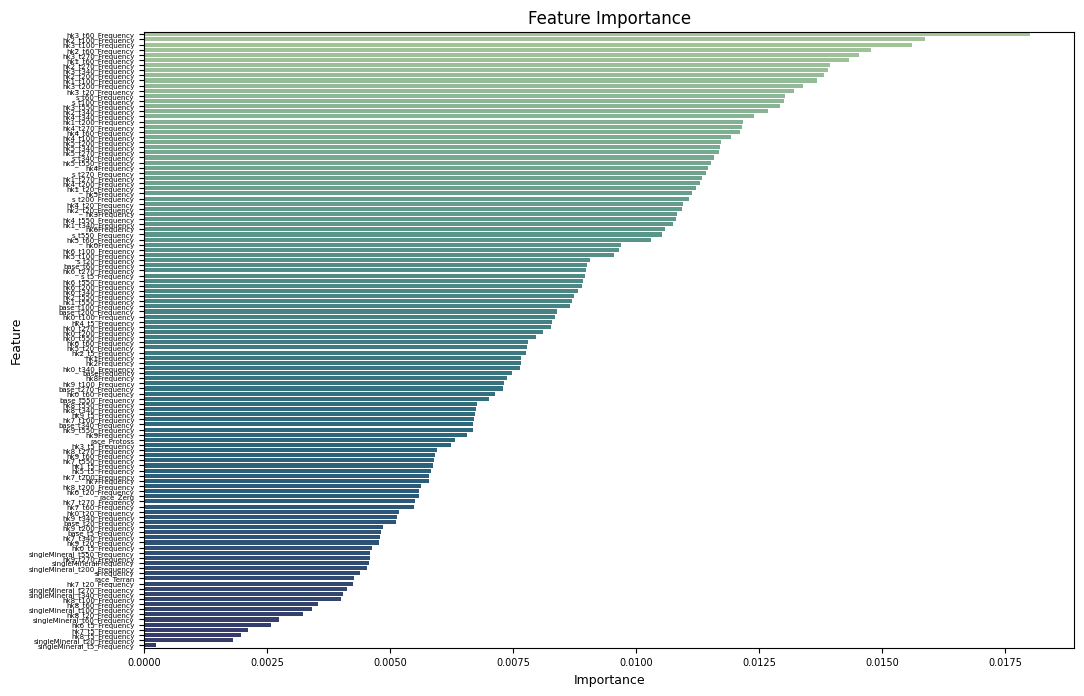

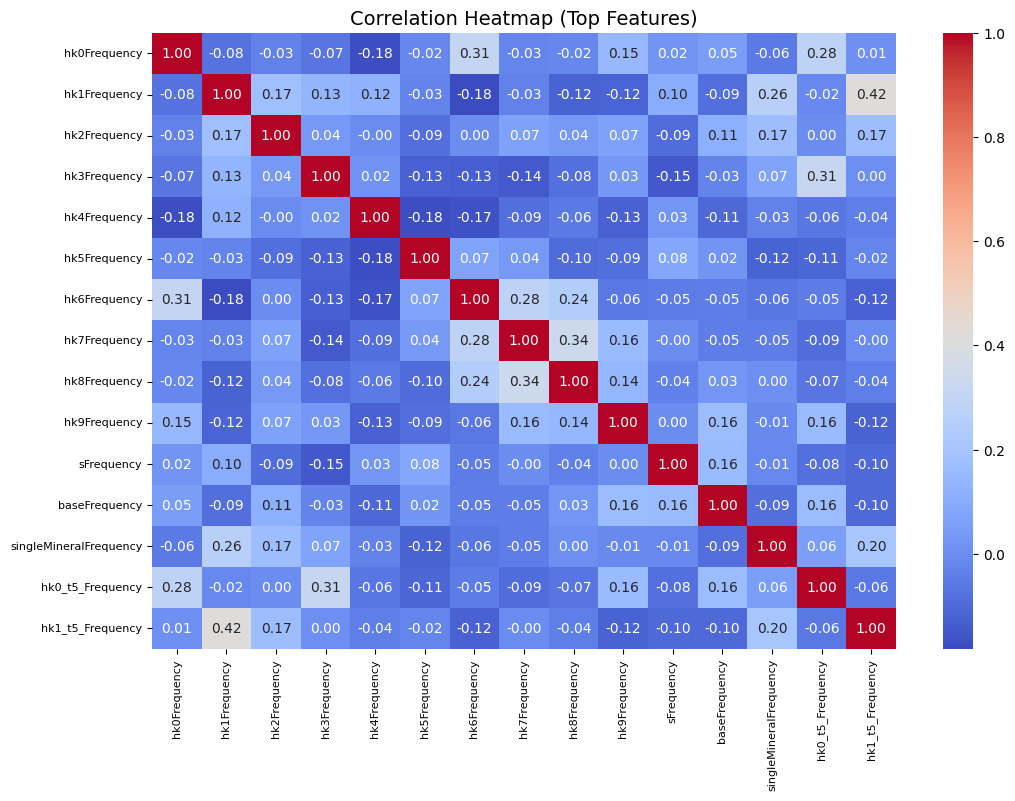

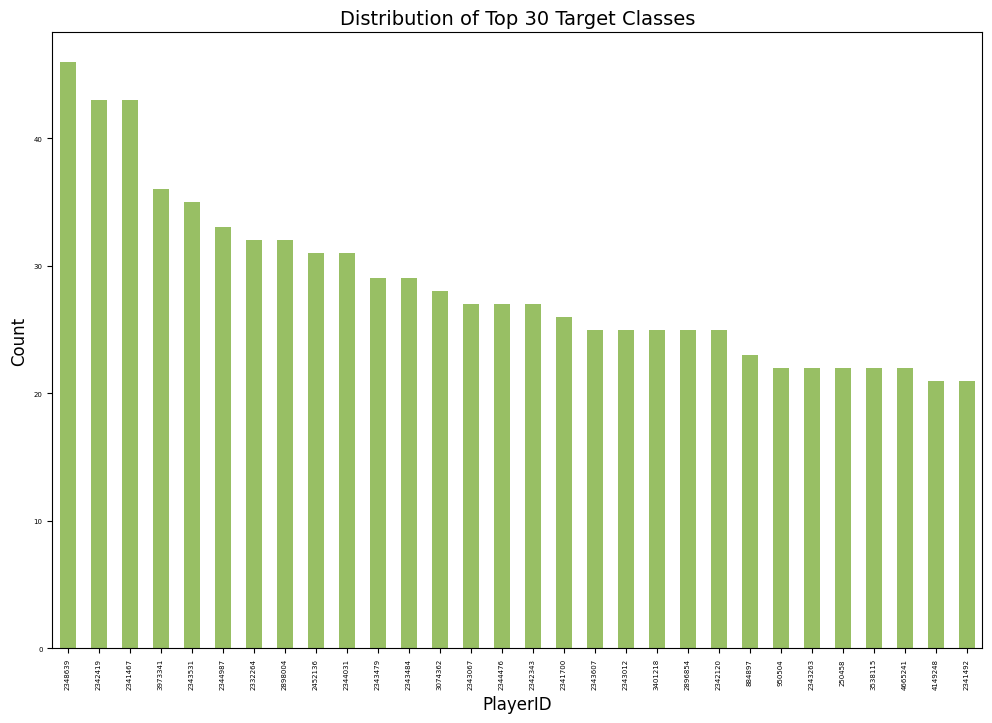

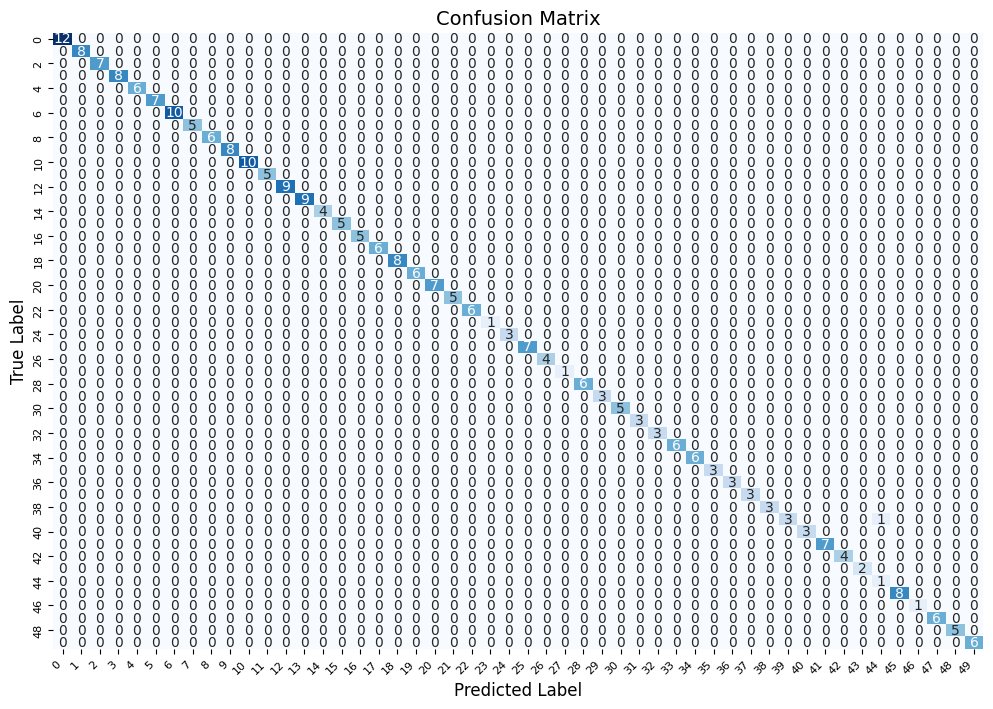

In [12]:
# Feature Importance
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_model.feature_importances_})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette="crest")
plt.title("Feature Importance", fontsize=12)
plt.xticks(fontsize=7)
plt.yticks(fontsize=5)
plt.xlabel("Importance", fontsize=9)
plt.ylabel("Feature", fontsize=9)
plt.show()

feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': boosting_model.feature_importances_})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Displaying the top correlated features
top_features = feature_importances_df.nlargest(15, 'Importance')['Feature']
correlation_matrix = pd.DataFrame(X_train[top_features]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Top Features)", fontsize=14)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Target Classes Distribution
top_classes = y_train.value_counts().nlargest(30)
plt.figure(figsize=(12, 8))
top_classes.plot(kind='bar', color="#98BF64")
plt.title("Distribution of Top 30 Target Classes", fontsize=14)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel("PlayerID", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix (after model prediction)
top_classes_cm = y_train.value_counts().nlargest(50)

conf_matrix = confusion_matrix(y_val, predictions, labels=top_classes_cm.index)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=8)
plt.show()





Furthermore we tried to use different ensemble methods: Stacking and Voting. With neither of them we achieved a higher score of accuracy so we decided to leave them out.

## Testing

When given the test data we were looking at almost the same pattern as the training data: Each row was a gameplay with a race and the moves made. Just the identifaction of the player was missing. That one was for us to predict and to do so we used our pretrained model.

In [6]:
# Load new data file 
test_data = pd.read_csv('test_data.csv', delimiter=';')
test_data.columns = ['Race'] + [f'Move_{i}' for i in range(1, 3446)]
test_data.head()

,Race,Move_1,Move_2,Move_3,Move_4,Move_5,Move_6,Move_7,Move_8,Move_9,...,Move_3436,Move_3437,Move_3438,Move_3439,Move_3440,Move_3441,Move_3442,Move_3443,Move_3444,Move_3445
0,Zerg,s,s,s,hotkey10,s,hotkey60,s,hotkey00,s,...,s,hotkey11,hotkey12,hotkey02,hotkey62,hotkey12,s,hotkey02,hotkey62,hotkey12
1,Terran,s,hotkey30,hotkey00,t5,s,hotkey32,s,hotkey32,s,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Protoss,Base,s,s,Base,s,hotkey20,hotkey30,hotkey60,hotkey40,...,t1110,hotkey22,hotkey62,hotkey22,hotkey12,hotkey22,s,hotkey72,t1115,hotkey22
3,Zerg,s,s,s,s,hotkey20,s,hotkey40,t5,t10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Protoss,Base,s,s,Base,s,hotkey50,hotkey30,t5,hotkey40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Testing Pre-processing

But before, we had to change the data in the same way we did with the training data. We did this, so they would be able to compare.

In [7]:
# Same preprocessing as in train_def so that we have save structured data
def count_moves(row, counts, index):
    total_moves = 0
    for i in range(1, 3446):
        move = row["Move_"+ str(i)]

        # count the number of s's
        if move == 's':
            counts[10][index] += 1
        # count the number of Base's
        elif move == 'Base':
            counts[11][index] += 1
        # count the number of SingleMineral's
        elif move == 'SingleMineral':
            counts[12][index] += 1
        # count the hotkeys
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[j][index] += 1
        total_moves += 1  
    # Save the total moves count
    counts[13][index] = total_moves


def count_move_per_time(row, counts, row_index, time_interval, ti_index):
    base_index = ti_index*14
    total_moves = 0
    for i in range(1, 3446):
        move = row["Move_" + str(i)]

        # Count actions for the given time interval
        if move == 's':
            counts[base_index + 10][row_index] += 1
        elif move == 'Base':
            counts[base_index + 11][row_index] += 1
        elif move == 'SingleMineral':
            counts[base_index + 12][row_index] += 1
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[base_index + j][row_index] += 1

        total_moves += 1

        # Continue counting actions after the specified time interval
        if move == f't{time_interval}':
            break

    counts[base_index + 13][row_index] = total_moves


def mapRaces(races, row_index):
    race = test_data['Race'][row_index]

    if race == "Protoss":
        races[0][row_index] = 1
    elif race == "Terran":
        races[1][row_index] = 1
    elif race == "Zerg":
        races[2][row_index] = 1
        

# Create new table that only contains the first column (Race) of test_data
# Keep only the first column but all rows
test_data_new = test_data.iloc[:, :1]

# Specify the target time intervals
# time_intervals = [20, 60, 100, 200]
time_intervals = [5, 20, 60, 100, 200, 270, 340, 550]

calc_column = len(time_intervals)* 14 + 14
# New lists of counts
counts = [[0] * 340 for _ in range(calc_column)]
# New lists of races
races = [[0] * 340 for _ in range(3)]


# Go through the rows using the functions to count the actions, map the races
for row_index, row in test_data.iterrows():
    count_moves(row, counts, row_index)
    mapRaces(races, row_index)

    for ti_index, time_interval in enumerate(time_intervals):
        count_move_per_time(row, counts, row_index, time_interval, ti_index+1)

# Adding all the new columns to the test_data_new
# Adding new columns for the count of moves
for i in range(calc_column):
    locals()[f'count_{i}'] = counts[i]

for i in range(10):
    test_data_new[f'hk{i}Frequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[i])]

test_data_new['sFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[10])]
test_data_new['baseFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[11])]
test_data_new['singleMineralFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[12])]

# Adding new columns for the count of moves per interval
for ti_index, time_interval in enumerate(time_intervals):
    base_index = (ti_index + 1) * 14
    for j in range(10):
        column_name = f'hk{j}_t{time_interval}_Frequency'
        test_data_new[column_name] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + j])]

    test_data_new[f's_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 10])]
    test_data_new[f'base_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 11])]
    test_data_new[f'singleMineral_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 12])]



# Adding new columns for the races
test_data_new['race_Protoss'] = races[0]
test_data_new['race_Terran'] = races[1]
test_data_new['race_Zerg'] = races[2]

# # Remove 30% of least important features
# columns_to_remove = ['hk1_t5_Frequency', 'race_Zerg', 'hk9_t60_Frequency', 'hk5_t5_Frequency', 'hk7_t60_Frequency', 'hk7_t550_Frequency', 'hk9_t340_Frequency', 'hk0_t20_Frequency', 'hk6_t20_Frequency', 'base_t20_Frequency', 'hk8_t200_Frequency', 'hk7_t270_Frequency', 'hk9_t20_Frequency', 'base_t5_Frequency', 'hk9_t200_Frequency', 'hk7_t340_Frequency', 'singleMineral_t550_Frequency', 'singleMineral_t200_Frequency', 'singleMineral_t340_Frequency', 'hk9_t270_Frequency', 'sFrequency', 'hk8_t100_Frequency', 'hk0_t5_Frequency', 'race_Terran', 'singleMineralFrequency', 'hk7_t20_Frequency', 'singleMineral_t270_Frequency', 'singleMineral_t100_Frequency', 'hk8_t60_Frequency', 'hk8_t20_Frequency', 'singleMineral_t60_Frequency', 'hk6_t5_Frequency', 'hk7_t5_Frequency', 'hk8_t5_Frequency', 'singleMineral_t20_Frequency', 'singleMineral_t5_Frequency']
# # Remove columns from DataFrame
# test_data_new = test_data_new.drop(columns=columns_to_remove)

test_data_new.head()

,Race,hk0Frequency,hk1Frequency,hk2Frequency,hk3Frequency,hk4Frequency,hk5Frequency,hk6Frequency,hk7Frequency,hk8Frequency,...,hk6_t550_Frequency,hk7_t550_Frequency,hk8_t550_Frequency,hk9_t550_Frequency,s_t550_Frequency,base_t550_Frequency,singleMineral_t550_Frequency,race_Protoss,race_Terran,race_Zerg
0,Zerg,0.249927,0.113208,0.022351,0.001451,0.000000,0.000000,0.285922,0.013643,0.000000,...,0.322067,0.015451,0.000000,0.010623,0.201352,0.008209,0.001449,0,0,1
1,Terran,0.010160,0.101597,0.052540,0.135849,0.117562,0.045864,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.012234,0.205409,0.000000,0.000000,0,1,0
2,Protoss,0.000290,0.128882,0.178520,0.084180,0.063570,0.000000,0.305660,0.009289,0.014224,...,0.356610,0.005330,0.014392,0.000000,0.139126,0.002132,0.000000,1,0,0
3,Zerg,0.000000,0.197968,0.042961,0.010450,0.154427,0.001451,0.001161,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.378223,0.010506,0.000955,0,0,1
4,Protoss,0.000871,0.024673,0.011030,0.007837,0.008418,0.024383,0.000000,0.001161,0.001451,...,0.000000,0.005319,0.008865,0.000000,0.345745,0.035461,0.000000,1,0,0


### Testing Predictions 

The pre-trained model was then loaded and used to make predictions about the players.

In [8]:
import joblib
# Load the pre-trained model
model_filename = 'player_id_prediction_model.pkl'
clf = joblib.load(model_filename)

features = test_data_new.drop(['Race'], axis=1)

# Use the loaded model to make predictions
predictions = clf.predict(features)

# Add predictions to the test_data_new DataFrame
test_data_new['Predicted_PlayerID'] = predictions

test_data_new.head()

,Race,hk0Frequency,hk1Frequency,hk2Frequency,hk3Frequency,hk4Frequency,hk5Frequency,hk6Frequency,hk7Frequency,hk8Frequency,...,hk7_t550_Frequency,hk8_t550_Frequency,hk9_t550_Frequency,s_t550_Frequency,base_t550_Frequency,singleMineral_t550_Frequency,race_Protoss,race_Terran,race_Zerg,Predicted_PlayerID
0,Zerg,0.249927,0.113208,0.022351,0.001451,0.000000,0.000000,0.285922,0.013643,0.000000,...,0.015451,0.000000,0.010623,0.201352,0.008209,0.001449,0,0,1,3538115
1,Terran,0.010160,0.101597,0.052540,0.135849,0.117562,0.045864,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.012234,0.205409,0.000000,0.000000,0,1,0,2896854
2,Protoss,0.000290,0.128882,0.178520,0.084180,0.063570,0.000000,0.305660,0.009289,0.014224,...,0.005330,0.014392,0.000000,0.139126,0.002132,0.000000,1,0,0,3973341
3,Zerg,0.000000,0.197968,0.042961,0.010450,0.154427,0.001451,0.001161,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.378223,0.010506,0.000955,0,0,1,250458
4,Protoss,0.000871,0.024673,0.011030,0.007837,0.008418,0.024383,0.000000,0.001161,0.001451,...,0.005319,0.008865,0.000000,0.345745,0.035461,0.000000,1,0,0,950504


At the end we created a .csv file with the results that we could upload to Kaggle. This meant merging the predicted player IDs with the first row of the training data to obtain the corresponding player URLs. 

In [9]:
# Load the training dataset
train_data = pd.read_csv('train_data.csv', delimiter=';')

# Extract 'PlayerID' and 'PlayerURL' columns
player = train_data[['PlayerID', 'PlayerURL']]

# take only one URL per each PlayerID
player_info = player.drop_duplicates(subset='PlayerID', keep='first')

# Extract 'Predicted_PlayerID' column
player_id_column = test_data_new[['Predicted_PlayerID']]

# Merge the predicted ID to get the url of the player
result = pd.merge(player_id_column, player_info, left_on='Predicted_PlayerID', right_on='PlayerID', how='left')

# take only the url for each player
result = result.drop(['Predicted_PlayerID', 'PlayerID'], axis=1)
# insert a new row in position 0 as asked for the submission and count the number of lines
result.insert(0,"RowId", range(1, len(result) + 1))

# Save 'PlayerURL' to CSV
result.to_csv('player_id_only.csv', index=False)

#player_info.head()
#player_id_column.head()
result.head()

,RowId,PlayerURL
0,1,http://eu.battle.net/sc2/en/profile/3538115/1/...
1,2,http://eu.battle.net/sc2/en/profile/2896854/1/...
2,3,http://eu.battle.net/sc2/en/profile/3973341/1/...
3,4,http://eu.battle.net/sc2/en/profile/250458/1/V...
4,5,http://eu.battle.net/sc2/en/profile/950504/1/G...


Afterwards we added some statistics to asses the testing performance. We wanted to see which predictions were made 

In [10]:
print("Count of Predicted PlayerIDs:")
print(test_data_new['Predicted_PlayerID'].value_counts())

Count of Predicted PlayerIDs:
Predicted_PlayerID
2348639    6
2341467    6
2342419    6
2343012    5
2343531    5
          ..
284466     1
2343183    1
414        1
404        1
401        1
Name: count, Length: 172, dtype: int64


And we wanted to see how many different players were predicted. We increased this score over time, because it meant our model was able differentiate better between players.

In [11]:
print("Count of Unique PlayerURLs:")
print(result['PlayerURL'].nunique())

Count of Unique PlayerURLs:
172


## Results

The first time we tested our model we only reached 44% on Kaggle. Over time, we managed to increase this score more and more. Finally, we reached a level of 82% testing accuracy and 93% training accuracy. 

### Improvements
We could make some improvements to our code by doing:
- Feature Engineering:
    We should consider additional features or transformations that might better capture the characteristics of our data and experiment with different aggregations, scaling, or encoding techniques. Another thing to do could be to check for highly correlated features and trying top remove the correlated features to reduce multicollinearity.
- Model Selection:
    Apart from the model already used, we could experiment with different machine learning models, that combines the results of other models, in order to obtain better results. Some examples could be Gradient Boosting, Support Vector Machines, or Neural Networks, which may capture complex patterns in the data.